<div style="border-radius: 10px; padding: 5px; background-color: lightblue; font-size:200%; text-align:left">
7. Update Hitran Linelist

<div style="border-radius: 10px; padding: 10px; background-color: #eaeaea; font-size:100%; text-align:left">
 
### In this notebook, we will:
* [7.1 | Handle the HITRAN line list](#handle)
* [7.2 | Load HITRAN line list - parse file](#parse)
    * Extracting J quantum number and symmetry from local quanta
* [7.3 | EDA on HITRAN data](#EDA)
    *  J_low, symmetry, etc. 
* [7.4 | Load 4th Pade fitted pressure broadening coefficients](#load_coeff)
* [7.5 | Update HITRAN with fitted pressure broadening data](#update_hitran)
    * Using fitted coefficients for each symmetry, calculate gamma_L for H2/He and calculate nT
    * Update line-by-line
    * Using multiple CPUs

In [1]:
# Import module
from Xpectra.FitLiteratureData import *
from Xpectra.LineAssigner import *

Loading BokehJS ...

<div style="border-radius: 10px; padding: 5px; background-color: lightblue; font-size:170%; text-align:left">
7.1 Handle HITRAN linelist

In [2]:
# Call environment variable and assign path to data
__reference_data_path__ = os.getenv("Xpectra_reference_data")

# Define file path
hitran_file = os.path.join(__reference_data_path__,'datasets','CH4_nu3.par')

<div style="font-size:120%; text-align:left">
$\rightarrow$ Initialize class: FitLiteratureData

In [3]:
# Create instance using path to HITRAN .par file
update_hitran = FitLiteratureData(hitran_file = hitran_file,
                                 __reference_data__ = __reference_data_path__)

<div style="border-radius: 10px; padding: 5px; background-color: lightblue; font-size:170%; text-align:left">
7.2 Load HITRAN line list - parse file

<div style="font-size:120%; text-align:left">
$\rightarrow$ With the class initialized, lets load the line list into memory by parsing the file into a DataFrame.

$\rightarrow$ Here we are also extracting J_low and symmetry C_low from local quanta expression 

In [4]:
# Parse file to DataFrame
update_hitran.parse_hitran_file()

<div style="border-radius: 10px; padding: 5px; background-color: lightblue; font-size:170%; text-align:left">
7.3 EDA on HITRAN data

<div style="font-size:120%; text-align:left">
$\rightarrow$ Let's explore the available data 

In [5]:
# Show header and first 5 columns
update_hitran.hitran_df.head()

,molec_id,local_iso_id,nu,sw,gamma_air,gamma_self,n_air,local_upper_quanta,local_lower_quanta,J_low,sym_low,N_low,J_up,sym_up,N_up
0,6,2,2900.000621,1.825000e-25,0.049,0.067,0.63,13A2 9,12A1 1,12,A1,1,13,A2,9
1,6,2,2900.005693,6.307000e-27,0.047,0.065,0.62,14F1 40,14F2 3,14,F2,3,14,F1,40
2,6,2,2900.022027,3.048000e-27,0.046,0.060,0.61,17F1 47,17F2 2,17,F2,2,17,F1,47
3,6,1,2900.027223,1.891000e-25,0.048,0.067,0.63,13F2 21,12F1 3,12,F1,3,13,F2,21
4,6,2,2900.035027,1.905000e-25,0.040,0.067,0.63,12E 25,12E 2,12,E,2,12,E,25


<div style="font-size:120%; text-align:left">
$\rightarrow$ The quanta expressions are now seperated into their parts:

In [6]:
update_hitran.hitran_df[['local_upper_quanta','J_up','N_up','sym_up', 'local_lower_quanta','J_low','N_low','sym_low']].head(10)

,local_upper_quanta,J_up,N_up,sym_up,local_lower_quanta,J_low,N_low,sym_low
0,13A2 9,13,9,A2,12A1 1,12,1,A1
1,14F1 40,14,40,F1,14F2 3,14,3,F2
2,17F1 47,17,47,F1,17F2 2,17,2,F2
3,13F2 21,13,21,F2,12F1 3,12,3,F1
4,12E 25,12,25,E,12E 2,12,2,E
5,18 10 E,18,10,E,19 7 E,19,7,E
6,14F2 40,14,40,F2,14F1 1,14,1,F1
7,12F1 36,12,36,F1,12F2 3,12,3,F2
8,13F1 22,13,22,F1,12F2 2,12,2,F2
9,13 8 E,13,8,E,14 1 E,14,1,E


In [7]:
# Check symmetries
update_hitran.hitran_df['sym_low'].dropna().unique()

array(['A1', 'F2', 'F1', 'E', 'A2'], dtype=object)

<div style="font-size:120%; text-align:left">
$\rightarrow$ The distribution and range of J quantum number in this HITRAN line list

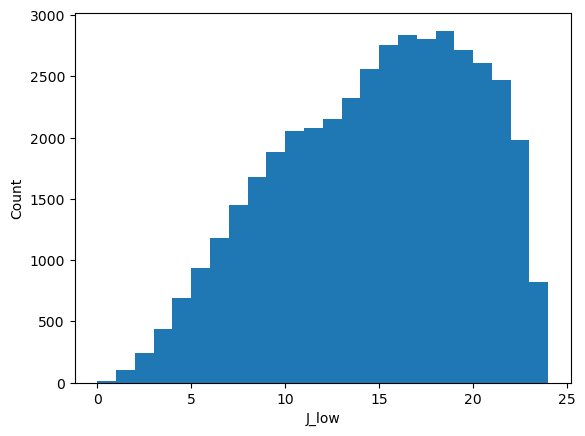

In [8]:
# Plot histogram of J_low
plt.hist(update_hitran.hitran_df['J_low'], bins=24)
plt.xlabel('J_low')
plt.ylabel('Count')
plt.show()

In [9]:
# Check non-null values
update_hitran.hitran_df.count()

molec_id              41628
local_iso_id          41628
nu                    41628
sw                    41628
gamma_air             41628
gamma_self            41628
n_air                 41628
local_upper_quanta    41628
local_lower_quanta    41628
J_low                 41628
sym_low               41628
N_low                 41628
J_up                  41628
sym_up                41628
N_up                  41628
dtype: int64

<div style="border-radius: 10px; padding: 5px; background-color: lightblue; font-size:170%; text-align:left">
7.4 Load fitted pressure broadening coefficients

<div style="font-size:120%; text-align:left">
$\rightarrow$ Next, we will use parameters of the 4th Pade equation, fitted with literature, to update the HITRAN data. First, let's import those coefficients we fitted in the last step: 

In [10]:
# Define file path
pbro_coeff_file = os.path.join(__reference_data_path__,'outputs','ch4_Pbroadening_4thPade.csv')

# Load coefficients
pbro = pd.read_csv(pbro_coeff_file)

In [11]:
# Display header and first 7 rows
pbro.head(7)

,coeff,abs,bro,sym_low,a0,a1,a2,a3,b1,b2,b3,b4
0,gamma_L,CH4,H2,A1,0.070000,-28739.842754,1527.618755,-27.399937,-418580.145555,20089.246650,-104.443746,-32.870420
1,gamma_L,CH4,H2,A2,0.070000,-1131.894063,53.781878,-0.809802,-16484.751276,794.607473,-18.403874,-0.626174
2,gamma_L,CH4,H2,E,0.070000,-263.072769,22.271939,-0.683776,-3470.478648,94.003676,17.318920,-1.265039
3,gamma_L,CH4,H2,F1,0.069610,-0.073627,0.004083,-0.000067,-1.034819,0.033477,0.001413,-0.000087
4,gamma_L,CH4,H2,F2,0.068634,-0.023844,0.000785,-0.000008,-0.350065,0.013530,-0.000435,-0.000002
5,n_T,CH4,H2,A1,0.769970,122.591760,-23.715542,2.410308,159.244294,-15.774117,-0.647397,0.283237
6,n_T,CH4,H2,A2,0.769999,1785.193329,-941.443828,123.274112,2191.586313,-1038.009986,94.392414,6.840596


<div style="border-radius: 10px; padding: 5px; background-color: lightblue; font-size:170%; text-align:left">
7.5 Update HITRAN with fitted P-bro data

<div style="font-size:120%; text-align:left">
    
$\rightarrow$ HITRAN line lists can be very large for a given molecule and wavenumber range, often including millions of lines. 

$\rightarrow$ Because of this, since we want to perform a calculation on each line, we'll use multiprocessing for this task. Parallization decreases the time to process significantly and doesn't overload memory. 

$\rightarrow$ We modify each line from the HITRAN file, calculating gamma_h2, gamma_he, and n_T from J_low and sym_low, and load into a new text file. 

In [12]:
# Replace lines in HITRAN file using parallel processing
update_hitran.replace_in_file_parallel(pb_coeffs = pbro,
                                       save_name = 'output_v3.txt',
                                       num_processes=8)

## Check the output: Updated HITRAN line list

In [13]:
# Define how to parse df
def parse_file_to_dataframe(input_file):
    """
    Parse an input file into a pandas DataFrame based on specified columns.

    Parameters
    ----------
    input_file : str
        Path to the input file to parse.
    selected_columns : list
        List of column names to select from the input file. Default is
        ['local_iso_id','nu','sw','gamma_air','local_upper_quanta']. 

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing parsed data from the input file.
    """
    # Define the formats and the ranges for the columns
    columns = {
        'molec_id': (0, 2, int, "%2d"),
        'local_iso_id': (2, 3, int, "%1d"),
        'nu': (3, 15, float, "%12.6f"),
        'sw': (15, 25, float, "%10.3e"),
        'a': (25, 35, float, "%10.3e"),
        'gamma_H2': (35, 40, float, "%5.4f"),
        'gamma_He': (40, 45, float, "%5.3f"),
        'elower': (45, 55, float, "%10.4f"),
        'n_T': (55, 59, float, "%4.2f"),
        'delta_air': (59, 67, float, "%8.6f"),
        'global_upper_quanta': (67, 82, str, "%15s"),
        'global_lower_quanta': (82, 97, str, "%15s"),
        'local_upper_quanta': (97, 112, str, "%15s"),
        'local_lower_quanta': (112, 127, str, "%15s"),
        'ierr': (127, 128, int, "%1d"),
        'iref': (128, 130, int, "%2d"),
        'line_mixing_flag': (130, 131, str, "%1s"),
        'gp': (131, 138, float, "%7.1f"),
        'gpp': (138, 145, float, "%7.1f")
    }

    parsed_data_list = []  # Initialize an empty list to store parsed data dictionaries

    with open(input_file, 'r') as infile:
        for line in infile:
            data = LineAssigner.parse_line(line, columns)
            parsed_data_list.append(data)  # Append each parsed line dictionary to the list

    df = pd.DataFrame(parsed_data_list)  # Convert list of dictionaries to DataFrame

    if 'local_lower_quanta' in df.columns: 
        # Seperate terms
        df[['J_low','sym_low','N_low']] = LineAssigner.parse_term_symbols(df['local_lower_quanta'])
    if 'local_upper_quanta' in df.columns:
        # Seperate terms
        df[['J_up','sym_up','N_up']] = LineAssigner.parse_term_symbols(df['local_upper_quanta'])

    return df

In [14]:
# Parse coefficients in .txt file 
edited_df = parse_file_to_dataframe(os.path.join(__reference_data_path__, 'outputs', 'output_v3.txt'))

# Show header
edited_df.head()

,molec_id,local_iso_id,nu,sw,a,gamma_H2,gamma_He,elower,n_T,delta_air,...,iref,line_mixing_flag,gp,gpp,J_low,sym_low,N_low,J_up,sym_up,N_up
0,6,2,2900.000621,1.825000e-25,0.023890,0.0576,0.023,814.6845,0.51,-0.0058,...,64,3,3253433.0,None,12,A1,1,13,A2,9
1,6,2,2900.005693,6.307000e-27,0.005030,0.0532,0.021,1096.0334,0.48,-0.0058,...,64,3,3253433.0,None,14,F2,3,14,F1,40
2,6,2,2900.022027,3.048000e-27,0.022620,0.0450,0.018,1593.6378,0.41,-0.0058,...,64,3,3253433.0,None,17,F2,2,17,F1,47
3,6,1,2900.027223,1.891000e-25,0.000465,0.0574,0.023,815.1315,0.51,-0.0058,...,34,3,3245363.0,None,12,F1,3,13,F2,21
4,6,2,2900.035027,1.905000e-25,0.067460,0.0463,0.019,815.0317,0.42,-0.0058,...,64,3,3253433.0,None,12,E,2,12,E,25


## Visualize calculated values: $\gamma_{\mathrm{_{H_{2}}}}$, gamma$\mathrm{_{He}}$, and n$\mathrm{_{T}}$ versus J$\mathrm{_{low}}$

In [15]:
# Mapping symmetry to colors
color_dict = {
    'A1': '#1f77b4',  
    'A2': '#ff7f0e',  
    'E':  '#2ca02c', 
    'F1': '#d62728',  
    'F2': '#9467bd',
    None: 'k'
    }
color_values = edited_df['sym_low'].map(color_dict)

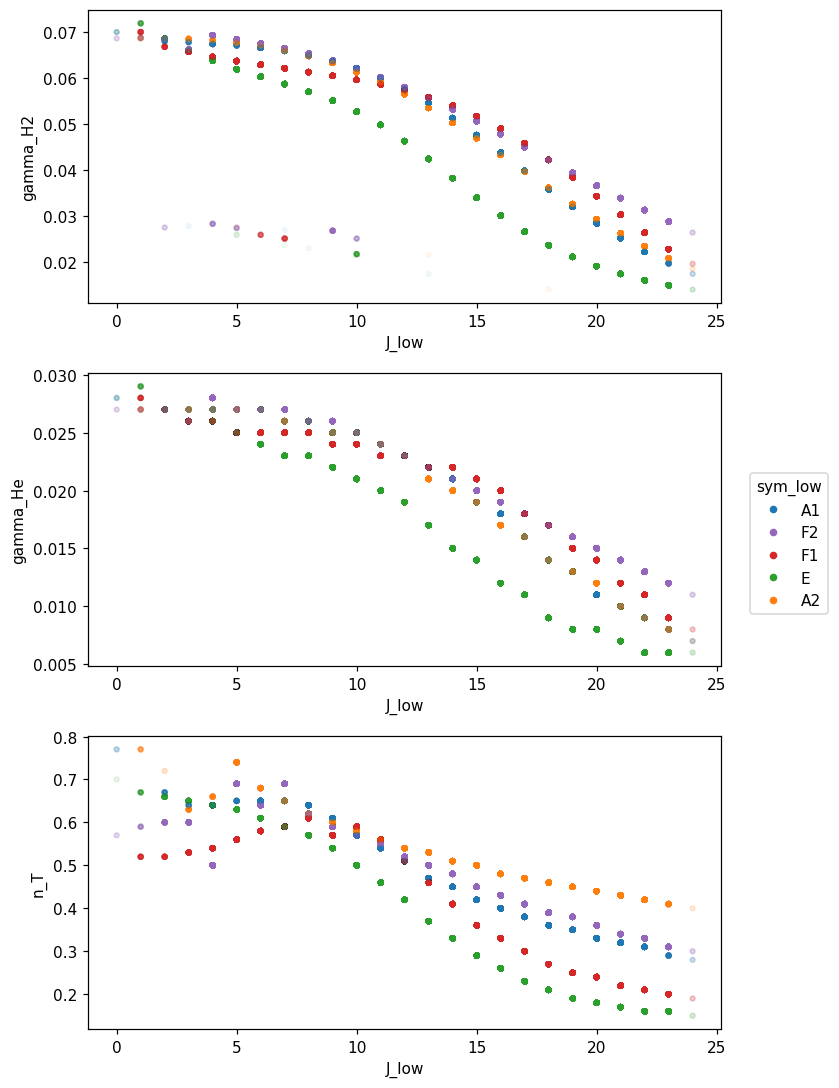

In [16]:
# Create Figure
fig, axes = plt.subplots(3,1, figsize=(8,10), dpi=110)
ax1,ax2,ax3 = axes

ax1.scatter(edited_df['J_low'], edited_df['gamma_H2'],s=10,alpha=0.05,c=color_values)
ax1.set_ylabel('gamma_H2')

ax2.scatter(edited_df['J_low'], edited_df['gamma_He'],s=10,alpha=0.05,c=color_values)
ax2.set_ylabel('gamma_He')

ax3.scatter(edited_df['J_low'], edited_df['n_T'],s=10,alpha=0.05,c=color_values)
ax3.set_ylabel('n_T')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('J_low')

# Create legend on the right side
unique_sym_values = edited_df['sym_low'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(value), 
                      markersize=6, markerfacecolor=color_dict[value]) for value in unique_sym_values]
fig.legend(handles=handles, title='sym_low', loc='center left', bbox_to_anchor=(0.85, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

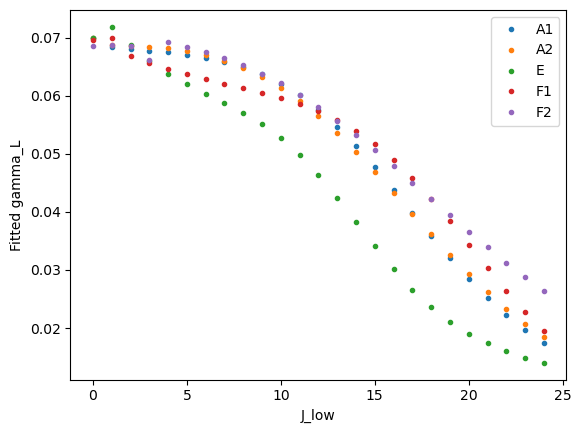

In [17]:
# Investigation - what the first panel should look like 

df_pbro = pbro
y_param = 'gamma_L'
J_range = [0,25]
__save_plot__ = False
__show_plot__ = True   

J_arr = np.arange(*J_range)
# df index
indeces = np.where(df_pbro['coeff'] == y_param)[0]

for index in indeces:
    coefficients = list(df_pbro.loc[index,'a0':'b4'].values)
    fitted_values = FitLiteratureData.fit_Pbro_Pade(J_arr, *coefficients)
    plt.plot(J_arr, fitted_values, '.', label= df_pbro.loc[index,'sym_low'])

plt.xlabel('J_low')
plt.ylabel(f'Fitted {y_param}')
plt.legend()

plt.show()

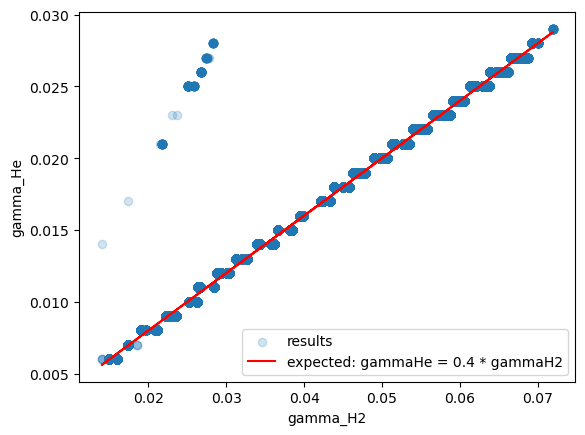

In [18]:
# Investigating weird points: 

plt.scatter(edited_df['gamma_H2'],edited_df['gamma_He'],alpha=0.2,label='results')
plt.plot(edited_df['gamma_H2'], edited_df['gamma_H2']*0.4,color='r',label='expected: gammaHe = 0.4 * gammaH2')

plt.xlabel('gamma_H2')
plt.ylabel('gamma_He')
plt.legend()

# END